In [ ]:
!git clone https://github.com/Artin200912/Data1

Cloning into 'Data1'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 226 (delta 1), reused 226 (delta 1), pack-reused 0
Receiving objects: 100% (226/226), 9.83 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [161]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow opencv-python matplotlib albumentations

### Importing the dependencies

In [ ]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import albumentations as alb
import shutil
import random
import numpy as np

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Playing with a Testing Dataset

In [ ]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [ ]:
type(images)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [ ]:
images.as_numpy_iterator().next()

b'data/images/25bc7163-03c1-11ef-a442-9bd93f0d0733.jpg'

# Mapping the images paths to images arrays

In [ ]:
def load_img(x):
  byte_img = tf.io.read_file(x)
  image = tf.io.decode_jpeg(byte_img)
  return image

In [ ]:
images = images.map(load_img)

In [ ]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

array([[[226, 220, 232],
        [224, 218, 230],
        [224, 218, 230],
        ...,
        [227, 243, 243],
        [229, 245, 245],
        [228, 244, 244]],

       [[226, 220, 232],
        [221, 215, 227],
        [219, 213, 225],
        ...,
        [228, 244, 244],
        [229, 245, 245],
        [227, 243, 243]],

       [[222, 216, 230],
        [219, 213, 227],
        [217, 214, 225],
        ...,
        [230, 244, 245],
        [229, 245, 245],
        [225, 241, 241]],

       ...,

       [[232, 244, 244],
        [230, 242, 242],
        [227, 239, 239],
        ...,
        [216, 230, 233],
        [212, 226, 229],
        [207, 221, 224]],

       [[230, 244, 245],
        [228, 242, 243],
        [225, 239, 240],
        ...,
        [218, 232, 235],
        [214, 228, 231],
        [209, 223, 226]],

       [[227, 241, 242],
        [228, 242, 243],
        [226, 240, 241],
        ...,
        [217, 231, 234],
        [213, 227, 230],
        [209, 223, 226]]], dtype=uint8)
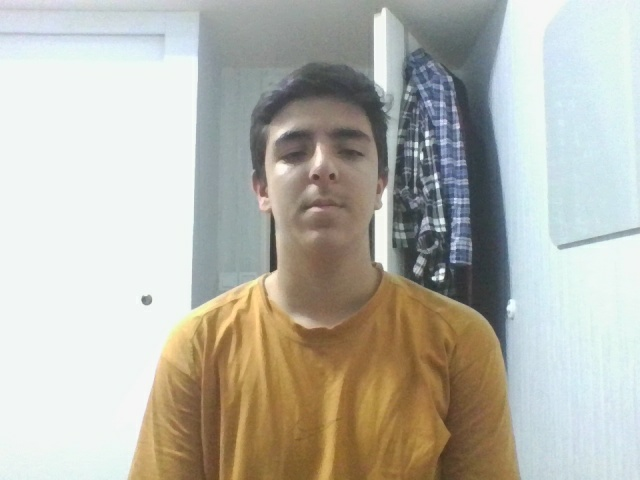

In [ ]:
images.as_numpy_iterator().next()

# plotting images from the dataset

In [ ]:
img_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plt_imgs = img_generator.next()

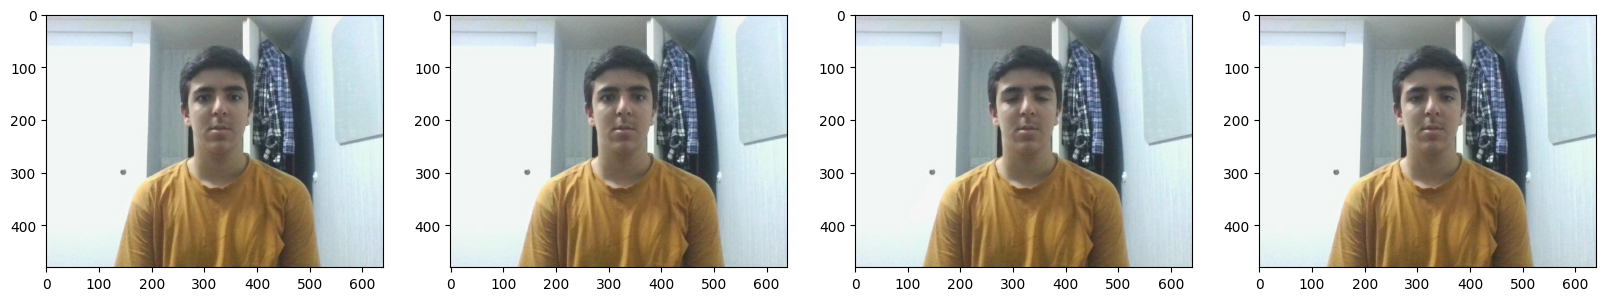

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx, image in enumerate(plt_imgs):
  ax[idx].imshow(image)

plt.show()

# Split our data into training, testing, validation

### make sure all the images are in the Image Directory

In [ ]:
data_dir = "/content/data"
images_dir = os.path.join(data_dir, "images")
train_dir = os.path.join(data_dir, "train", "images")
val_dir = os.path.join(data_dir, "val", "images")
test_dir = os.path.join(data_dir, "test", "images")

train_images = os.listdir(train_dir)
for image in train_images:
    shutil.move(os.path.join(train_dir, image), os.path.join(images_dir, image))

val_images = os.listdir(val_dir)
for image in val_images:
    shutil.move(os.path.join(val_dir, image), os.path.join(images_dir, image))

test_images = os.listdir(test_dir)
for image in test_images:
    shutil.move(os.path.join(test_dir, image), os.path.join(images_dir, image))

for directory in [train_dir, val_dir, test_dir]:
    if len(os.listdir(directory)) == 0:
        os.rmdir(directory)

for directory in [os.path.join(data_dir, "train"), os.path.join(data_dir, "val"), os.path.join(data_dir, "test")]:
    if len(os.listdir(directory)) == 0:
        os.rmdir(directory)

In [ ]:
data_dir = '/content/data'
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train', 'images')
test_dir = os.path.join(data_dir, 'test', 'images')
val_dir = os.path.join(data_dir, 'val', 'images')


image_file = os.listdir(images_dir)
random.shuffle(image_file)


train_count = 78
val_count = 20
test_count = 14


for i in range(train_count):
  image = image_file.pop()
  shutil.move(os.path.join(images_dir, image), os.path.join(train_dir, image))

for i in range(val_count):
  image = image_file.pop()
  shutil.move(os.path.join(images_dir, image), os.path.join(val_dir, image))

for i in range(test_count):
  image = image_file.pop()
  shutil.move(os.path.join(images_dir, image), os.path.join(test_dir, image))

### Move the labels to the labels directory inside of their corresponding partition

In [ ]:
folders = ['train', 'test', 'val']
for folder in folders:
  for file in os.listdir(os.path.join('data', folder, 'images')):

    filename = file.split(".")[0] + '.json'

    existing_filepath = os.path.join('data', 'labels', filename)

    if os.path.exists(existing_filepath):
      new_filepath = os.path.join('data', folder, 'labels', filename)
      os.replace(existing_filepath, new_filepath)

#Augmenting the data

In [ ]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),

    alb.HorizontalFlip(p=0.5),

    alb.RandomBrightnessContrast(p=0.4),

    alb.RandomGamma(p=0.3),

    alb.RGBShift(p=0.5),

    alb.VerticalFlip(p=0.5),

],
bbox_params = alb.BboxParams(
    format='albumentations',
    label_fields = ['class_labels']
))

In [ ]:
img = cv2.imread(os.path.join('data', 'train', 'images', '2840d0d3-03c1-11ef-911a-9bd93f0d0733.jpg'))

In [ ]:
with open(os.path.join('data', 'train', 'labels', '2840d0d3-03c1-11ef-911a-9bd93f0d0733.json'), 'r') as f:
  label = json.load(f)

In [ ]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[267.56097560975616, 106.34146341463413],
    [383.65853658536594, 270.2439024390244]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\2840d0d3-03c1-11ef-911a-9bd93f0d0733.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAV

In [ ]:
label['shapes'][0]['points']

[[267.56097560975616, 106.34146341463413],
 [383.65853658536594, 270.2439024390244]]

In [ ]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [ ]:
coords

[267.56097560975616, 106.34146341463413, 383.65853658536594, 270.2439024390244]

In [ ]:
img.shape

(480, 640, 3)

In [ ]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [ ]:
coords

[0.418064024390244,
 0.22154471544715446,
 0.5994664634146343,
 0.5630081300813008]

### apply the augmentor shiftings to 1 img

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes']

[(0.554092140921409,
  0.43501355013550136,
  0.8120867208672086,
  0.7992411924119242)]

### plot the augmented img

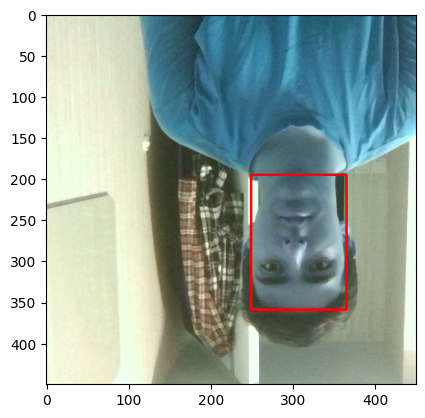

In [ ]:
# Draw a rectangle around the object in the augmented image using OpenCV
cv2.rectangle(
    augmented['image'],  # Image on which the rectangle will be drawn
    tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),  # Top-left corner coordinates
    tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),  # Bottom-right corner coordinates
    (255, 0, 0),  # Color of the rectangle (in BGR format, so (255, 0, 0) is blue)
    2  # Thickness of the rectangle's edges
)

# Display the augmented image with the rectangle drawn using Matplotlib
plt.imshow(augmented['image'])

### Apply the augmention to all the images

In [ ]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### Load the images , normalize them and resize them, map them through the load_img function

In [ ]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)

train_images = train_images.map(load_img)

train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))

train_images = train_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)

val_images = val_images.map(load_img)

val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))

val_images = val_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)

test_images = test_images.map(load_img)

test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))

test_images = test_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

array([[[0.8749387 , 0.91023284, 0.94442403],
        [0.87708336, 0.9123775 , 0.93982846],
        [0.8791054 , 0.9143995 , 0.93400735],
        ...,
        [0.6732843 , 0.7438725 , 0.7595588 ],
        [0.9206495 , 0.9760417 , 0.9878064 ],
        [0.96862745, 1.        , 1.        ]],

       [[0.8463848 , 0.8895221 , 0.9130515 ],
        [0.8313113 , 0.8754902 , 0.8988358 ],
        [0.84117645, 0.8857843 , 0.9009804 ],
        ...,
        [0.66764706, 0.7343137 , 0.7617647 ],
        [0.9341299 , 0.99442405, 0.9992647 ],
        [0.95931375, 1.        , 0.997549  ]],

       [[0.8519608 , 0.90294117, 0.9264706 ],
        [0.8520833 , 0.9030637 , 0.9265931 ],
        [0.8607843 , 0.91568625, 0.92745095],
        ...,
        [0.6978554 , 0.7645221 , 0.79197305],
        [0.92291665, 0.9832108 , 0.9944853 ],
        [0.9495098 , 1.        , 0.9972426 ]],

       ...,

       [[0.98039216, 0.99607843, 1.        ],
        [0.97990197, 0.9965686 , 1.        ],
        [0.9769608 , 1

### Load the labels

In [ ]:
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding='utf-8') as f:
    label = json.load(f)

  return [label['class']], label['bbox']

In [ ]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)

train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)

val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)

test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4263, 0.1993, 0.718 , 0.532 ], dtype=float16))

# The final part of the dataset

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
type(train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
train.as_numpy_iterator().next()

(array([[[[0.80202204, 0.91182595, 0.9157475 ],
          [0.79479164, 0.9045956 , 0.9091299 ],
          [0.7862745 , 0.8960784 , 0.9078431 ],
          ...,
          [0.6696078 , 0.75980395, 0.73137254],
          [0.65294117, 0.74313724, 0.71960783],
          [0.6632353 , 0.74852943, 0.7243872 ]],
 
         [[0.8050858 , 0.92273283, 0.92273283],
          [0.79473037, 0.9123775 , 0.9123775 ],
          [0.79313725, 0.9107843 , 0.91764706],
          ...,
          [0.6927083 , 0.7824142 , 0.7603554 ],
          [0.6847426 , 0.77101713, 0.7597426 ],
          [0.7045343 , 0.7908088 , 0.77953434]],
 
         [[0.7995098 , 0.9171569 , 0.9171569 ],
          [0.8       , 0.91764706, 0.91764706],
          [0.80355394, 0.921201  , 0.921201  ],
          ...,
          [0.688174  , 0.7862132 , 0.7744485 ],
          [0.70594364, 0.79221815, 0.784375  ],
          [0.7030637 , 0.78541666, 0.78933823]],
 
         ...,
 
         [[0.7325368 , 0.85018384, 0.8423407 ],
          [0.74613

# Creating the model

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, GlobalMaxPooling2D, Input
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
def build_model():
  input_layer = Input(shape=(120, 120, 3))

  vgg = VGG16(include_top=False)(input_layer)

  # The classification part
  f1 = GlobalMaxPooling2D()(vgg)
  class1 = Dense(2048, activation='relu')(f1)
  class2 = Dense(1, activation='sigmoid')(class1)

  # The regression part
  f2 = GlobalMaxPooling2D()(vgg)
  regress1 = Dense(2048, activation='relu')(f2)
  regress2 = Dense(4, activation='sigmoid')(regress1)

  facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
  return facetracker

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                              

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 3s 3s/step


(array([[0.56577885],
        [0.6170255 ],
        [0.617236  ],
        [0.5259403 ],
        [0.6191316 ],
        [0.57113874],
        [0.5097958 ],
        [0.56705964]], dtype=float32),
 array([[0.5592334 , 0.5446497 , 0.48389363, 0.41566142],
        [0.5263592 , 0.46166277, 0.4582449 , 0.31628433],
        [0.5909085 , 0.56744486, 0.47522053, 0.37933987],
        [0.48679313, 0.446864  , 0.39734966, 0.45576248],
        [0.56563896, 0.5182793 , 0.49752054, 0.33023876],
        [0.59868234, 0.3995231 , 0.41641977, 0.36407107],
        [0.5259951 , 0.4783341 , 0.483459  , 0.3714864 ],
        [0.5541309 , 0.3874732 , 0.4000518 , 0.41879994]], dtype=float32))

### defining neccessary variables

In [ ]:
batch_per_epoch = len(train)

lr_decay = (1./0.75 -1)/batch_per_epoch

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [ ]:
def localization_loss(y_true, yhat):
    # Calculate the squared difference between the x and y coordinates of the true and predicted bounding boxes
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    # Calculate the height and width of the true bounding boxes
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    # Calculate the height and width of the predicted bounding boxes
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    # Calculate the squared difference between the height and width of the true and predicted bounding boxes
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    # Sum of the squared coordinate differences and the squared size differences
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### Defining the Final Model class

In [ ]:
class FaceTracker(Model):
    def __init__(self, facetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

In [ ]:
hist = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100
585/585 [==============================] - 47s 63ms/step - total_loss: 0.1498 - class_loss: 0.0322 - regress_loss: 0.1338 - val_total_loss: 0.0574 - val_class_loss: 4.6527e-04 - val_regress_loss: 0.0572
Epoch 2/100
585/585 [==============================] - 40s 61ms/step - total_loss: 0.0600 - class_loss: 0.0119 - regress_loss: 0.0541 - val_total_loss: 0.0387 - val_class_loss: 1.7761e-04 - val_regress_loss: 0.0387
Epoch 3/100
585/585 [==============================] - 40s 61ms/step - total_loss: 0.0258 - class_loss: 0.0029 - regress_loss: 0.0244 - val_total_loss: 0.0845 - val_class_loss: 2.6198e-05 - val_regress_loss: 0.0845
Epoch 4/100
585/585 [==============================] - 40s 61ms/step - total_loss: 0.0197 - class_loss: 9.4141e-04 - regress_loss: 0.0192 - val_total_loss: 1.3534 - val_class_loss: 0.5970 - val_regress_loss: 1.0549
Epoch 5/100
585/585 [==============================] - 40s 61ms/step - total_loss: 0.0204 - class_loss: 0.0033 - regress_loss: 0.0188 - val_

In [ ]:
hist.history

{'total_loss': [0.027832303196191788,
  0.09699153900146484,
  0.010151446796953678,
  0.012074424885213375,
  0.005151172634214163,
  0.008029592223465443,
  0.01570446975529194,
  0.01822117529809475,
  0.015101904980838299,
  0.006139985751360655,
  0.014207444153726101,
  0.017215803265571594,
  0.006094297394156456,
  0.0038685868494212627,
  0.008031141012907028,
  0.007440751884132624,
  0.0019519779598340392,
  0.004000208340585232,
  0.00715686846524477,
  0.0016292763175442815,
  0.004140729550272226,
  0.0009872799273580313,
  0.0010974097531288862,
  0.005958834197372198,
  0.002398516982793808,
  0.002012074925005436,
  0.002335576107725501,
  0.0006938682054169476,
  0.0007865593652240932,
  0.001357381115667522,
  0.0007346222409978509,
  0.00043476425344124436,
  0.001293144770897925,
  0.0005997666157782078,
  0.0007199145038612187,
  0.0013340883888304234,
  0.0005948960315436125,
  0.0005235893768258393,
  0.0007780012092553079,
  0.000614507938735187,
  0.0003747502

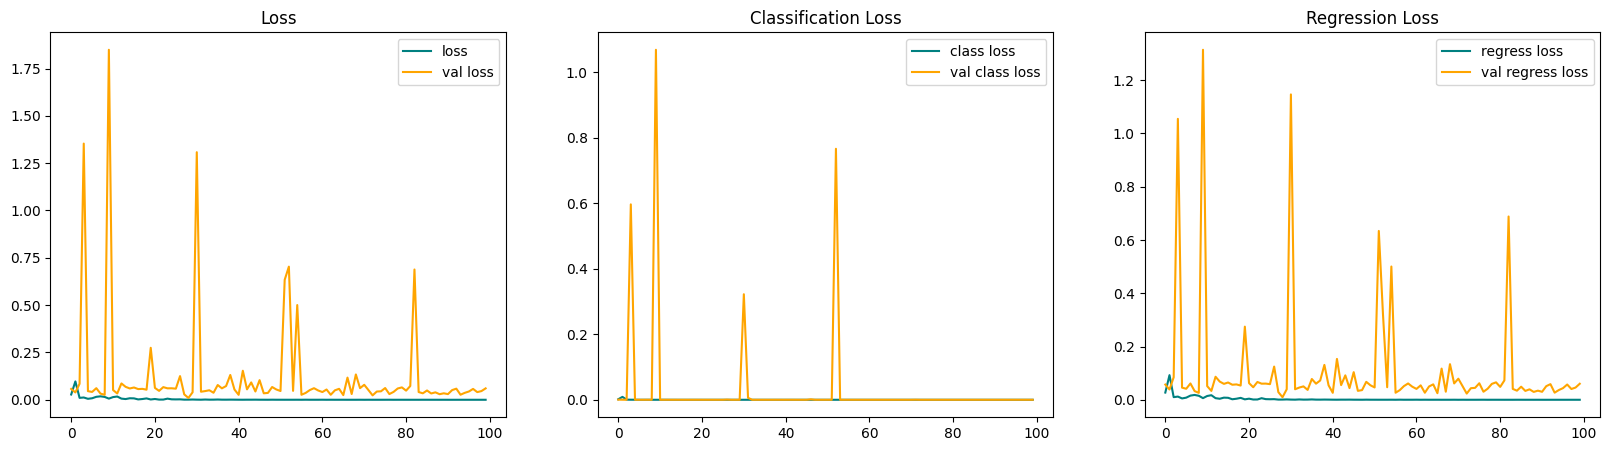

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
data_samp = test.as_numpy_iterator()

In [ ]:
res = data_samp.next()

In [ ]:
yhat = facetracker.predict(res[0])

1/1 [==============================] - 0s 18ms/step


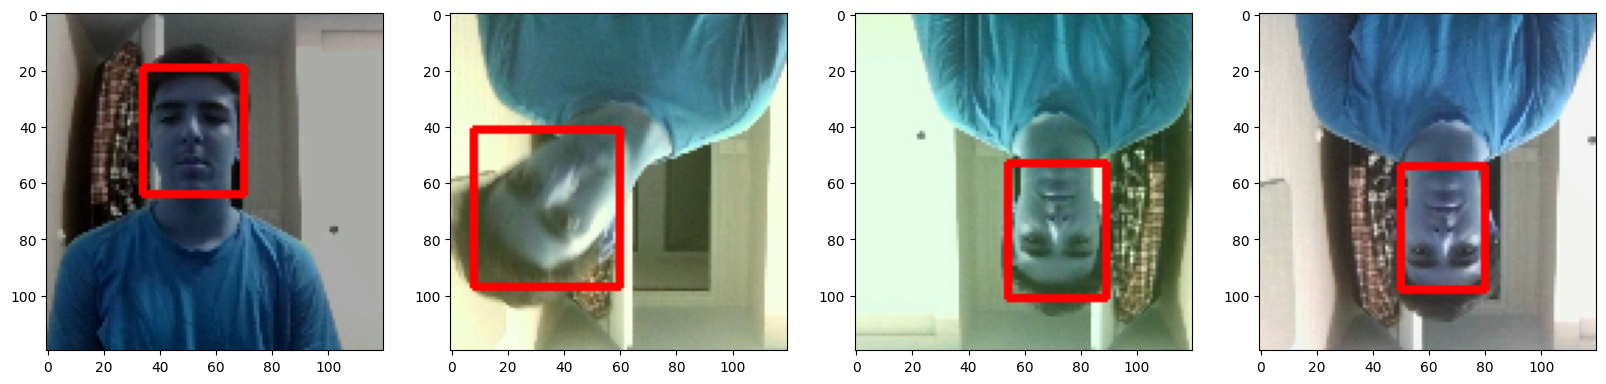

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [ ]:
facetracker.save('facetracker.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
facetracker = load_model('facetracker.h5')